In [18]:
install.packages("themis")

also installing the dependencies ‘fastmatch’, ‘ParamHelpers’, ‘BBmisc’, ‘checkmate’, ‘parallelMap’, ‘XML’, ‘mlr’, ‘doParallel’, ‘FNN’, ‘recipes’, ‘generics’, ‘RANN’, ‘ROSE’, ‘unbalanced’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [ ]:
#Loading needed libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
library("themis")
set.seed(9999)

In [28]:
#Load dataset into Jupyter
ccData <- read_excel('data/default-cc-data.xls')  
head(ccData)

New names:
* `` -> ...1



...1,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,⋯,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [31]:
#Tidy data by 
#  taking out columns on Education, marriage and payments, 
#  renaming the columns, 
#  slicing out top two rows, 
#  Changing data types from character to numeric for all columns except for default status
#  Changing the values for default_status to yes/no to make it readable
#  Creating new columns that have the ratio debt to balance limit for each month across all rows*
#
#
#
#Our hypothesis is that people with higher debt loads, that is the amount of debt they have relative to their balance limit, 
#  and whose debt load increases over time, are more likely to default. That is why we are creating new colums that have the
#  debt to limit ratio and using these as our predictor. 

clean_ccData = ccData %>%
    select(-c(X2:X11))%>% 
    rename(client_id = "...1", 
           limit_bal = X1,
           sep_bill = X12 , 
           aug_bill= X13 ,
           july_bill= X14,
           june_bill= X15,
           may_bill= X16, 
           april_bill=X17,
           sep_paid= X18 ,
           aug_paid= X19, 
           july_paid= X20, 
           june_paid= X21 ,
           may_paid= X22 ,
           april_paid= X23,
           default_status = Y)%>%
    slice(2:30001) %>%
    mutate_if(is.character, as.numeric) %>%
    mutate(client_id = as.character(client_id),
           default_status = case_when(default_status =="1"~"yes",
                                     default_status== "0"~"no"),
           default_status = as.factor(default_status),
           apr_debt_ratio = april_bill/limit_bal,
           may_debt_ratio = may_bill/limit_bal,
           jun_debt_ratio = june_bill/limit_bal,
           jul_debt_ratio = july_bill/limit_bal,
           aug_debt_ratio = aug_bill/limit_bal,
           sep_debt_ratio = sep_bill/limit_bal) %>%
    select(client_id, limit_bal, default_status, sep_debt_ratio : apr_debt_ratio)

head(clean_ccData)

client_id,limit_bal,default_status,sep_debt_ratio,aug_debt_ratio,jul_debt_ratio,jun_debt_ratio,may_debt_ratio,apr_debt_ratio
<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20000,yes,0.1956500,0.1551000,0.0344500,0.00000000,0.00000000,0.0000000
2,120000,yes,0.0223500,0.0143750,0.0223500,0.02726667,0.02879167,0.0271750
3,90000,no,0.3248778,0.1558556,0.1506556,0.15923333,0.16608889,0.1727667
4,50000,no,0.9398000,0.9646600,0.9858200,0.56628000,0.57918000,0.5909400
5,50000,no,0.1723400,0.1134000,0.7167000,0.41880000,0.38292000,0.3826200
6,50000,no,1.2880000,1.1413800,1.1521600,0.38788000,0.39238000,0.4004800


In [32]:
#Since our theory is that people who have higher debt load and whose debt is increasing month to month, we need to see if there
#  is an overall difference in debt load between those who defaulted and those who didn't. To test this, we are taking the 
#  average debt load for each group every available month and seeing if there is a difference in average debt load and how it
#  changes over time. This table shows these averages. 

ratio_averages = clean_ccData %>%
    group_by(default_status) %>%
    summarize(apr_avg = mean(apr_debt_ratio),
              bmay_avg = mean(may_debt_ratio),
              cjun_avg = mean(jun_debt_ratio),
              djul_avg = mean(jul_debt_ratio),
              eaug_avg = mean(aug_debt_ratio),
              fsep_avg = mean(sep_debt_ratio)) %>%
    pivot_longer(cols = apr_avg:fsep_avg,
                 names_to = "Month",
                 values_to = "avg_debt_ratio")
ratio_averages

`summarise()` ungrouping output (override with `.groups` argument)



default_status,Month,avg_debt_ratio
<fct>,<chr>,<dbl>
no,apr_avg,0.2958815
no,bmay_avg,0.3108478
no,cjun_avg,0.3367254
no,djul_avg,0.3702399
no,eaug_avg,0.3897752
no,fsep_avg,0.4048764
yes,apr_avg,0.3985191
yes,bmay_avg,0.4114814
yes,cjun_avg,0.4396978


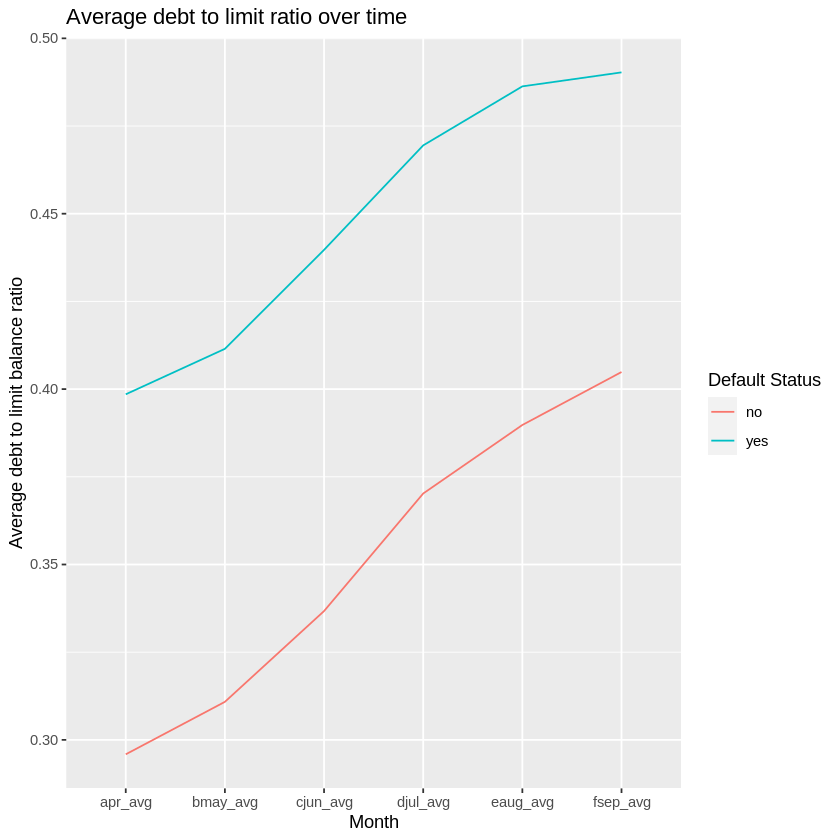

In [33]:
# Plot of the above table which plots the average debt load each month for both groups. 

# TODO --  change the labels for each month
# TODO -- Increase font size and make plot wider
debt_ratio_plot = ratio_averages %>%
    ggplot(aes(x=Month, y=avg_debt_ratio, color=default_status)) +
    geom_line(data=ratio_averages, aes(group=default_status)) +
    labs(x="Month", 
         y="Average debt to limit balance ratio", 
         color="Default Status", 
         title="Average debt to limit ratio over time")
debt_ratio_plot

In [27]:
debt_split = initial_split(clean_ccData, prop = 0.75, strata = default_status)
debt_train = training(debt_split)
debt_test = testing(debt_split)

debt_recipe = recipe(default_status ~ sep_debt_ratio + aug_debt_ratio 
                     + jul_debt_ratio + may_debt_ratio + apr_debt_ratio, data = debt_train) %>%
               step_upsample(default_status, over_ratio = 1, skip = FALSE) %>%
                prep()
debt_recipe
#  I tried applying an upsample to the data to see if I could improve accuracy, but it actually lowered it. 

debt_spec = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# TODO: Commenting out so it doesn't take forever to run every time I reopen Jupyter. Make sure to uncomment for final version
# debt_vfold = vfold_cv(debt_train, v=5, strata = default_status)

# gridvals = tibble(neighbors = seq(1, 200, by=10))

# debt_results = workflow() %>%
#     add_recipe(debt_recipe) %>%
#     add_model(debt_spec) %>%
#     tune_grid(resamples = debt_vfold, grid = gridvals)%>%
#     collect_metrics()
# debt_results

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Training data contained 22500 data points and no missing data.

Operations:

Up-sampling based on default_status [trained]

In [9]:
vfold_plot = debt_results %>%
    filter(.metric == "accuracy") %>%
    ggplot(aes(x=neighbors, y=mean)) +
    geom_line()
vfold_plot


ERROR: Error in eval(lhs, parent, parent): object 'debt_results' not found


In [ ]:
final_spec = nearest_neighbor(weight_func = "rectangular", neighbors = 100) %>%
    set_engine("kknn") %>%
    set_mode("classification")

final_fit = workflow() %>%
    add_recipe(debt_recipe) %>%
    add_model(final_spec) %>%
    fit(data = debt_train)
final_fit

debt_test_predictions = predict(final_fit, debt_test) %>%
    bind_cols(debt_test)
debt_test_predictions

In [ ]:
accuracy = debt_test_predictions %>%
    metrics(truth = default_status, estimate = .pred_class) 

confidence = debt_test_predictions %>%
    conf_mat(truth = default_status, estimate = .pred_class)

accuracy
confidence

In [ ]:
test
